In [ ]:
# !pip install tweet-preprocessor
# !pip install sastrawi
# !pip install emoji
# !pip install PySastrawi
# !pip install scikit-learn==1.6.0

### ***Import Libraries***

In [1]:
import pandas as pd
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.Stemmer.Stemmer import Stemmer
from nltk.corpus.reader.twitter import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import re
import string
import nltk
from nltk.corpus import stopwords
import numpy as np
from sklearn.model_selection import train_test_split

# Naive-Bayes' Package
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

### ***Data Preprocessing***

In [2]:
class TextCleaning:
    def __init__(self, glossary, stopwords):
        self.glossary = dict(zip(glossary['slang'], glossary['formal']))
        self.stopwords = list(stopwords)
        self.factory = StemmerFactory()
        self.stemmer = self.factory.create_stemmer()
        self.tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

    def clean_text(self, text):
        #tokenize tweet

        text_tokens = self.tokenizer.tokenize(text)

        text_clean = []
        for word in text_tokens:
          if (word not in self.stopwords and
              word not in string.punctuation):
            stem_word = self.stemmer.stem(word)
            text_clean.append(stem_word)
        return text_clean

    #remove punct
    def remove_punct(self, text_list):
      text = " ".join([char for char in text_list if char not in string.punctuation])
      return text

        #Fungsi Prepocessing

    def preprocess(self, text):
      text = text.lower() # lowercasing
      text = re.sub(r'[^0-9a-zA-Z]+', ' ', text) # non-alpha numeric
      text = re.sub(r'[\d+]+', '', text) # numeric
      text = re.sub(r'\\x[0-9a-fA-F]{2}', '', text) # emoji
      text = ' '.join([self.glossary[word] if word in self.glossary else word for word in text.split()]) # normalize
      text = ' '.join(['' if word in self.stopwords else word for word in text.split()]) # stopwords
      text = self.remove_punct(self.clean_text(text)) # punctuation
      return text

In [3]:
class CreateVocabulary:
    def __init__(self, dataset, preprocessor):
        self.dataset = dataset
        self.preprocessor = preprocessor

    def create_corpus(self):
        if type(self.dataset) == pd.core.frame.DataFrame:
          return list(self.dataset['remarks'])
        elif type(self.dataset) == list:
          return list(pd.concat(self.dataset)['remarks'])
        else:
          return None

    def create_vocabulary(self):
        corpus = self.create_corpus()
        vocabulary_list = [self.preprocessor.preprocess(text).split() for text in corpus]
        vocabulary = sum(vocabulary_list, [])
        vocabulary = list(set(vocabulary))
        vocabulary.sort()
        vocabulary = dict(zip(vocabulary, range(len(vocabulary))))
        return vocabulary

In [4]:
train = pd.read_csv("Dataset/train_data.csv", index_col=0).reset_index(drop=True)
test = pd.read_csv("Dataset/test_data.csv", index_col=0).reset_index(drop=True)
stopwords = pd.read_csv("Dataset/stopwords.csv")["stopwords"]
glossary = pd.read_csv("Dataset/glossary.csv", index_col=0).reset_index(drop=True)


In [5]:
preprocessor = TextCleaning(glossary=glossary, stopwords=stopwords)
vocabulary = CreateVocabulary([train, test], preprocessor).create_vocabulary()

In [6]:
text = "Saya berkunjung ke rmh kons. fu jb besok pg ada ,a .!?"
c = TextCleaning(glossary=glossary, stopwords=stopwords).preprocess(text)
print(c)

kunjung rumah konsumen follow up janji bayar besok pagi


In [7]:
print(vocabulary)

{'abai': 0, 'abang': 1, 'abar': 2, 'abd': 3, 'abdi': 4, 'abgkat': 5, 'abk': 6, 'absen': 7, 'acara': 8, 'access': 9, 'account': 10, 'aceh': 11, 'activity': 12, 'activty': 13, 'ada': 14, 'adabertemu': 15, 'adaby': 16, 'adainfo': 17, 'adajanji': 18, 'adajb': 19, 'adak': 20, 'adakons': 21, 'adaplan': 22, 'adarumah': 23, 'adasedang': 24, 'adaybs': 25, 'adc': 26, 'address': 27, 'adek': 28, 'adha': 29, 'adi': 30, 'adik': 31, 'adike': 32, 'adiknyaunit': 33, 'adisucipto': 34, 'adiyasa': 35, 'admin': 36, 'ads': 37, 'adu': 38, 'afniaty': 39, 'agency': 40, 'agenda': 41, 'agmon': 42, 'agun': 43, 'agung': 44, 'agustus': 45, 'agya': 46, 'ahanf': 47, 'ahir': 48, 'ahli': 49, 'ahmad': 50, 'air': 51, 'airmadidi': 52, 'ajak': 53, 'ajar': 54, 'aji': 55, 'ajik': 56, 'ajikpenekanan': 57, 'aju': 58, 'aka': 59, 'akam': 60, 'akansegera': 61, 'akgor': 62, 'akher': 63, 'akhie': 64, 'akhir': 65, 'akhirbulan': 66, 'akibat': 67, 'akqn': 68, 'akses': 69, 'aktf': 70, 'aktif': 71, 'aktiffam': 72, 'aktiv': 73, 'aktiviti

### ***Vectorizer***

In [8]:
count = CountVectorizer(preprocessor=preprocessor.preprocess, vocabulary=vocabulary)
X_train = count.fit_transform(train['remarks'])
X_test = count.fit_transform(test['remarks'])
y_train = train['label']
y_test = test['label']

### ***Naive Bayes Model***

In [9]:
# Membuat param_grid dengan range 0-5 by 0.5
param_grid = {'alpha': np.arange(0.1, 10.1, 0.1).tolist()}

# GridSearchCV
grid = GridSearchCV(MultinomialNB(), param_grid, cv=10, scoring='accuracy')
grid.fit(X_train, y_train)

# Menampilkan 3 parameter terbaik
results = grid.cv_results_
top_3_indices = np.argsort(results['mean_test_score'])[-3:][::-1]  # Indeks 3 skor terbaik (descending)

print("Top 3 Parameters:")
for idx in top_3_indices:
    print(f"Parameter: {results['params'][idx]}, Mean Accuracy: {results['mean_test_score'][idx]:.4f}")

Top 3 Parameters:
Parameter: {'alpha': 0.7000000000000001}, Mean Accuracy: 0.7373
Parameter: {'alpha': 0.6}, Mean Accuracy: 0.7369
Parameter: {'alpha': 0.4}, Mean Accuracy: 0.7365


In [10]:
# Predict
nb = MultinomialNB(alpha=0.3).fit(X_train, y_train)
pred_nb = nb.predict(X_test)
print("Accuracy", accuracy_score(y_test,pred_nb))

print(f'confusion matrix:\n {confusion_matrix(y_test, pred_nb)}')
print(classification_report(y_test, pred_nb, zero_division=0))

Accuracy 0.7444444444444445
confusion matrix:
 [[87  1  3  2  3  0  0]
 [ 5 57  4  4  2  7  2]
 [ 5  2 63  3  3  8  4]
 [ 0  8  0 73  1  0  2]
 [ 2  5  2  3 75  0  3]
 [ 2  9  5  5  5 68  4]
 [ 5 10  6 10 11  5 46]]
                    precision    recall  f1-score   support

 business location       0.82      0.91      0.86        96
             house       0.62      0.70      0.66        81
            office       0.76      0.72      0.74        88
other family house       0.73      0.87      0.79        84
  other rent house       0.75      0.83      0.79        90
            others       0.77      0.69      0.73        98
           unknown       0.75      0.49      0.60        93

          accuracy                           0.74       630
         macro avg       0.74      0.75      0.74       630
      weighted avg       0.75      0.74      0.74       630



In [11]:
# Predictions for both training and test data
train_nb = nb.predict(X_train)

# Accuracy for both training and test data
train_accuracy = accuracy_score(y_train, train_nb)
test_accuracy = accuracy_score(y_test, pred_nb)

# Output the results
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Training Accuracy: 0.8956349206349207
Test Accuracy: 0.7444444444444445


In [12]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
# Cross-validation untuk mengecek kestabilan model
cv_nb = cross_val_score(nb, X_train, y_train, cv=10)
print("Akurasi cross-validation:", cv_nb)
print(cv_nb.mean())

Akurasi cross-validation: [0.71428571 0.79761905 0.71031746 0.75793651 0.76984127 0.74206349
 0.71031746 0.74603175 0.71031746 0.70238095]
0.7361111111111112


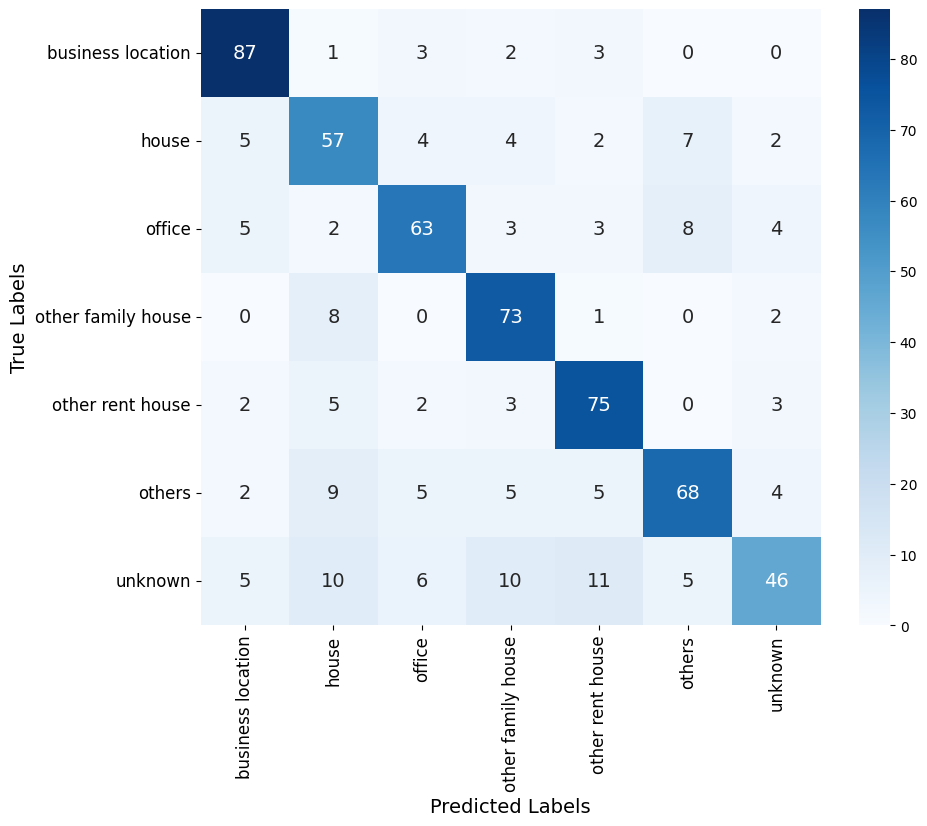

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ambil label kelas berdasarkan nilai maksimum prediksi
y_pred_classes = np.array(pred_nb)
y_true_classes = np.array(y_test)

# Hitung confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix dengan ukuran tulisan yang lebih besar
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=nb.classes_, yticklabels=nb.classes_,
            annot_kws={"size": 14})  # Mengatur ukuran tulisan
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [14]:
text=[test['remarks'][0]]

In [15]:
count.fit_transform(text)

<1x3180 sparse matrix of type '<class 'numpy.int64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [16]:
nb.predict(count.transform(text))

array(['other family house'], dtype='<U18')

In [17]:
model=make_pipeline(CountVectorizer(preprocessor=preprocessor.preprocess, vocabulary=vocabulary), MultinomialNB(alpha=0.7))

In [18]:
model.fit(train['remarks'], train['label'])

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(preprocessor=<bound method TextCleaning.preprocess of <__main__.TextCleaning object at 0x000001E3ED1276A0>>,
                                 vocabulary={'abai': 0, 'abang': 1, 'abar': 2,
                                             'abd': 3, 'abdi': 4, 'abgkat': 5,
                                             'abk': 6, 'absen': 7, 'acara': 8,
                                             'access': 9, 'account': 10,
                                             'aceh': 11, 'activity': 12,
                                             'activty': 13, 'ada': 14,
                                             'adabertemu': 15, 'adaby': 16,
                                             'adainfo': 17, 'adajanji': 18,
                                             'adajb': 19, 'adak': 20,
                                             'adakons': 21, 'adaplan': 22,
                                             'adarumah': 23, 'adasedang': 24,
                                             'adaybs': 25, 'adc': 26,
                                             'address': 27, 'adek': 28,
                                             'adha': 29, ...})),
                ('multinomialnb', MultinomialNB(alpha=0.7))])

In [19]:
model.predict(text)

array(['other family house'], dtype='<U18')

In [ ]:
import pickle
with open('MultinomialNB_ver1.1.pkl', 'wb') as f:
    pickle.dump(model, f)

In [21]:
# with open('MultinomialNB_ver1.0_update.pkl', 'rb') as f:
#     model_load = pickle.load(f)

In [22]:
# model_load.predict(text)

In [23]:
# # prompt: show the wrong prediction from X_test but in the format of the original remarks before it was vectorized

# import numpy as np
# import pandas as pd

# # Assuming 'X_test', 'y_test', 'pred_nb', 'test' (original dataframe), and 'preprocessor' are defined as in your provided code.

# # Find indices where predictions are wrong
# wrong_predictions_indices = np.where(y_test != pred_nb)[0]

# # Extract original remarks from the test set for the wrong predictions
# wrong_predictions_remarks = test.iloc[wrong_predictions_indices]['remarks']

# # Print the original remarks along with their predicted and true labels
# for i, remark in enumerate(wrong_predictions_remarks):
#     predicted_label = pred_nb[wrong_predictions_indices[i]]
#     true_label = y_test.iloc[wrong_predictions_indices[i]]
#     print(f"Original Remark: {remark}")
#     print(f"Predicted Label: {predicted_label}")
#     print(f"True Label: {true_label}")
#     print("-" * 20)